**Neural networks for road segmentation**
========================

Your next task is to train neural network to segment road on images from car cams.

The original dataset is provided by Karlsruhe Institute of Technology (http://www.cvlibs.net/datasets/kitti/eval_road.php). Their images are ±370x1270, but, for simlictiy, we will use 370x370 squares.

One can download the dataset from https://disk.yandex.ru/d/QPOw4hk84-se_w

Here is an example of input data with corresponding ground truth:

In [1]:
import os
import cv2
import numpy as np

import torch
import torch.nn as nn
import albumentations as A
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T

from albumentations.pytorch import ToTensorV2
from torchsummary import summary
from torch.utils.data import Dataset
from tqdm.notebook import tqdm as tqdm
from torch.utils.data import Dataset

%matplotlib inline

In [2]:
def get_paths(path):
    _, _, filenames = next(os.walk(path))

    images_paths = []
    for filename in sorted(filenames):            
        images_paths.append(os.path.join(path, filename))
    
    return np.stack(images_paths)

class RoadDataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, images, masks, transform):
        self.images = sorted(images)
        self.masks = sorted(masks)
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        im_name = self.images[idx]
        mask_name = self.masks[idx]
        
        image = cv2.imread(im_name)[:,:,::-1] / 255.0  # ::-1 to convert from BGR to RGB
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)
            
        augmented = self.transform(image=image,
                                   mask=mask)
        sample = {}
        sample['image'] = augmented['image']
        sample['mask'] = augmented['mask']

        return sample

In [3]:
X_train = get_paths("./data/train/images")
y_train = get_paths("./data/train/gt")

X_test = get_paths("./data/test/images")
y_test = get_paths("./data/test/gt")

train_transform = A.Compose([
    A.HorizontalFlip(),
    A.RandomRotate90(),
    A.RandomGamma(p=0.5),
#     A.ColorJitter(p=0.5),
    A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
    ], p=0.25),
    A.PadIfNeeded(min_height=512, min_width=512),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.PadIfNeeded(min_height=512, min_width=512),
    ToTensorV2(),
])

In [4]:
train_dataset = RoadDataset(X_train, y_train, train_transform)
test_dataset = RoadDataset(X_test, y_test, test_transform)

torch.Size([3, 512, 512]) torch.Size([512, 512])


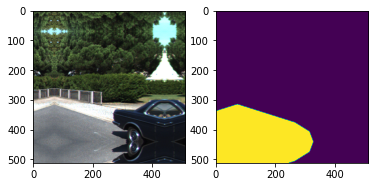

In [5]:
sample = train_dataset[4]
image = sample['image']
mask = sample['mask']

print(image.shape, mask.shape)
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask)

Workflow:
---
* Choose correct loss function, write training loop and code for testing. Feel free to use previous HW for inspiration. 
* Train any segmentation neural network from scratch (for example U-Net) and achieve >= 0.75 IoU on test set (40% points). See function to calculate the metric below.
* Use any pretrained model for image classification, convert it for segmentation by adding decoder (don't forget skip-connections) or usign dilated convolutions and achieve >= 0.87 IoU  on test set (60% points).

You're not allowed to do only one thing: train your network on test set.

----
Your final solution will consist of an ipython notebook with code (for final networks training + any experiments with data) and test metric calculation.

Feel free to ask in Telegram chat if something is not clear :3


In [6]:
print(f"Dataset length {len(train_dataset)}")

Dataset length 648


Dataset is small so actively use data augmentation: rotations, flip, color-change etc. to prevent overfitting.

Most likely you'll have to pad your images to 512x512 (it divides by 2^5=32, like U-Net wants). Use PadIfNeeded from Albumentations and central crop (see below) after prediction to calculate loss/metrics (you don't want to pay attention on padded values).

----
There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for the "road" class, or add class weights in optimized loss. You also can try to use softIoU or DICE loss.

Good luck!

### Model U-Net

In [7]:
class ConvLayer(nn.Module):
    
    def __init__(self, input_channels, output_channels, mid_channels=None, padding='same'):
        super().__init__()
        
        if mid_channels is None:
            mid_channels = output_channels
            
        self.conv1 = nn.Conv2d(in_channels=input_channels, 
                               out_channels=mid_channels,
                               kernel_size=(3, 3),
                               padding=padding)
        self.conv2 = nn.Conv2d(in_channels=mid_channels, 
                               out_channels=output_channels,
                               kernel_size=(3, 3),
                               padding=padding)
        
        self.dropout2d = nn.Dropout2d(0.2)
        self.use_dropout = True
        
        self.batchnorm1 = nn.BatchNorm2d(num_features=output_channels)
        self.batchnorm2 = nn.BatchNorm2d(num_features=output_channels)
        
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        
    
    def forward(self, input):
        x = self.conv1(input)
        x = self.relu1(x)
        x = self.batchnorm1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.batchnorm2(x)
        
        if self.use_dropout:
            x = self.dropout2d(x)
        
        return x

In [8]:
class DownScaller(nn.Module):
    
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.maxpool = nn.MaxPool2d(kernel_size = (2, 2))
        self.conv_layer = ConvLayer(input_channels, output_channels)
    
    def forward(self, input):
        x = self.maxpool(input)
        x = self.conv_layer(x)

        return x

In [9]:
class UpScaler(nn.Module):
    
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv_layer = ConvLayer(input_channels, output_channels, input_channels // 2)
        self.conv_transposed = nn.ConvTranspose2d(input_channels, input_channels // 2, kernel_size=2, stride=2)   
    
    def forward(self, x1, x2):
        x1 = self.conv_transposed(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv_layer(x)
        
        return x
        

In [10]:
class UNet(nn.Module):
    
    def __init__(self):
        super().__init__()
                
        self.input_channel = 3
        self.output_channel = 16
        self.n_classes = 1
        
        self.conv1 = ConvLayer(self.input_channel, self.output_channel)
        
        self.down1 = DownScaller(self.output_channel * 1, self.output_channel * 2)
        self.down2 = DownScaller(self.output_channel * 2, self.output_channel * 4)
        self.down3 = DownScaller(self.output_channel * 4, self.output_channel * 8)
        self.down4 = DownScaller(self.output_channel * 8, self.output_channel * 16)
        self.down5 = DownScaller(self.output_channel * 16, self.output_channel * 32)
        
        self.up1 = UpScaler(self.output_channel * 32, self.output_channel * 16)
        self.up2 = UpScaler(self.output_channel * 16, self.output_channel * 8)
        self.up3 = UpScaler(self.output_channel * 8, self.output_channel * 4)
        self.up4 = UpScaler(self.output_channel * 4, self.output_channel * 2)
        self.up5 = UpScaler(self.output_channel * 2, self.output_channel * 1)

        self.conv3 = nn.Conv2d(self.output_channel * 1, self.n_classes, kernel_size=(3, 3), padding='same')
        self.sigmoid = nn.Sigmoid()
        
    
    def forward(self, input):
               
        x_1 = self.conv1(input)
        x_2 = self.down1(x_1)
        x_3 = self.down2(x_2)
        x_4 = self.down3(x_3)
        x_5 = self.down4(x_4)
        x_6 = self.down5(x_5)

        x_7 = self.up1(x_6, x_5)
        x_8 = self.up2(x_7, x_4)      
        x_9 = self.up3(x_8, x_3)
        x_10 = self.up4(x_9, x_2)
        x_11 = self.up5(x_10, x_1)
        
        output = self.conv3(x_11)
        output = self.sigmoid(output)
        
        return output

In [11]:
# CHECK
unet = UNet()
a = torch.rand([4, 3, 512, 512])
out = unet(a)

print(out.shape)

torch.Size([4, 1, 512, 512])


### Train U-Net

In [12]:
# model = UNet().to(device)
# summary(model, input_size=train_dataset[0]['image'].shape)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 10
EPOCHS = 20
learning_rate = 0.01

In [14]:
def calc_iou(pred, target):
    pred = pred.view(-1).contiguous()
    target = target.view(-1).contiguous()

    intersection = (pred * target).sum()                            
    iou = intersection / (pred.sum() + target.sum() - intersection) 
    
    return iou

def calc_dice(pred, target, alpha = 0.5):
    pred = pred.view(-1).contiguous()
    target = target.view(-1).contiguous()

    intersection = (pred * target).sum()                            
    dice = (2 * intersection + alpha) / (pred.sum() + target.sum() + alpha) 
    
    return dice

def calc_focal(pred, target, alpha=0.8, gamma=2, smooth=1):  
    pred = pred.view(-1)
    target = target.view(-1)

    BCE = F.binary_cross_entropy(pred, target, reduction='mean')
    BCE_EXP = torch.exp(-BCE)
    focal_loss = alpha * (1 - BCE_EXP) ** gamma * BCE

    return focal_loss

def calc_loss(pred, target):
#     weights = torch.eye(target.shape[0]) * 1 + 1
    
    bce_loss = F.binary_cross_entropy(pred, target.unsqueeze(1), 
#                                                   weight=weights.to(device)
                                                 )
    dice_loss = 1 - calc_dice(pred, target)
    
    loss = bce_loss + dice_loss
    
#     focal_loss = calc_focal(pred, target)
    
    return loss

In [15]:
def train_model(model, data_loader, optimizer):
    loss_history = []
    iou_history = []
    
    for batch in tqdm(data_loader, desc='TRAIN'):
        x_batch, y_batch = batch['image'].to(device).float(), batch['mask'].to(device).float()
        
        optimizer.zero_grad()
        
        output = model(x_batch)
        loss = calc_loss(output, y_batch)
        loss.backward()
           
        optimizer.step()
        
        loss_history.append(loss.item())
        iou_history.append(calc_iou(output, 
                                    y_batch).cpu().detach().numpy())
        
    print(f'Loss: {np.mean(loss_history):.3f} ± {np.std(loss_history):.3f}\
            IoU: {np.mean(iou_history):.3f}  ± {np.std(iou_history):.3f}')
    
    return model

In [16]:
@torch.no_grad()
def eval_model(model, data_loader, scheduler):
    loss_history = []
    iou_history = []
    
    for batch in tqdm(data_loader, desc='VALID'):
        x_batch, y_batch = batch['image'].to(device).float(), batch['mask'].to(device).float()
        
        output = model(x_batch)
        loss = calc_loss(output, y_batch)
        
        loss_history.append(loss.item() )
        iou_history.append(calc_iou(output, 
                                    y_batch).cpu().detach().numpy())
    
    scheduler.step(np.mean(loss_history))
    
    print(f'Loss: {np.mean(loss_history):.3f} ± {np.std(loss_history):.3f}\
            IoU: {np.mean(iou_history):.3f}  ± {np.std(iou_history):.3f}\n')
    
    image = test_dataset[0]['image'].to(device).float()
    pred_mask = model(image[None, :, :, :])
    
    plt.subplot(1, 2, 1)
    plt.imshow(image.cpu().permute(1, 2, 0))
    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
    plt.show()

In [17]:
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE,
                                           num_workers=12)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, 
                                          num_workers=12)

In [ ]:
# tensorboard
# print each loss
# use dilate
# use not custom loss

EPOCH:   0%|          | 0/20 [00:00<?, ?it/s]

-------------------------------------------------- Epoch 1 / 20 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 1.050 ± 0.507            IoU: 0.344  ± 0.127


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 1.271 ± 0.396            IoU: 0.248  ± 0.139



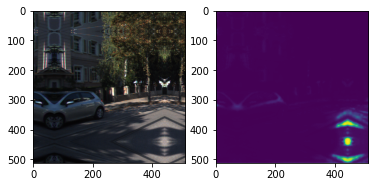

-------------------------------------------------- Epoch 2 / 20 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.657 ± 0.187            IoU: 0.514  ± 0.087


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 1.723 ± 0.466            IoU: 0.074  ± 0.055



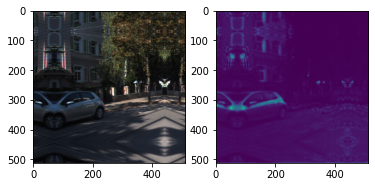

-------------------------------------------------- Epoch 3 / 20 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.600 ± 0.179            IoU: 0.547  ± 0.100


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.703 ± 0.195            IoU: 0.431  ± 0.161



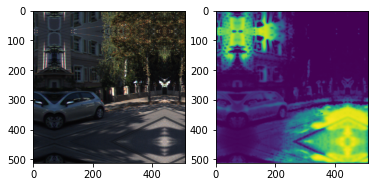

-------------------------------------------------- Epoch 4 / 20 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.587 ± 0.164            IoU: 0.549  ± 0.096


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.762 ± 0.386            IoU: 0.524  ± 0.224



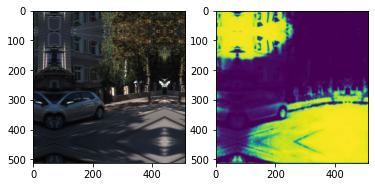

-------------------------------------------------- Epoch 5 / 20 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.569 ± 0.146            IoU: 0.566  ± 0.082


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.595 ± 0.247            IoU: 0.539  ± 0.188



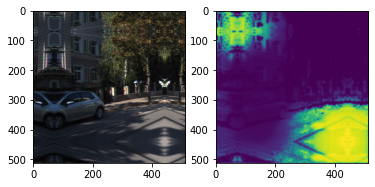

-------------------------------------------------- Epoch 6 / 20 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.528 ± 0.170            IoU: 0.594  ± 0.091


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.636 ± 0.323            IoU: 0.496  ± 0.212



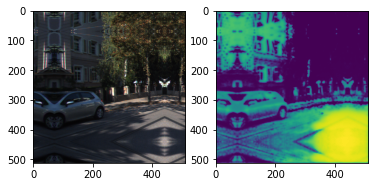

-------------------------------------------------- Epoch 7 / 20 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.591 ± 0.186            IoU: 0.550  ± 0.104


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 1.188 ± 0.325            IoU: 0.226  ± 0.129



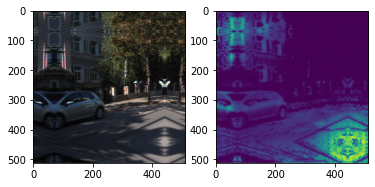

-------------------------------------------------- Epoch 8 / 20 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.539 ± 0.158            IoU: 0.586  ± 0.098


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.571 ± 0.314            IoU: 0.531  ± 0.213



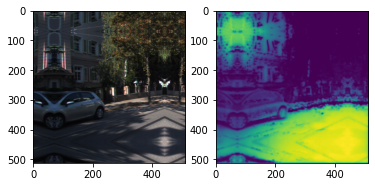

-------------------------------------------------- Epoch 9 / 20 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.578 ± 0.200            IoU: 0.562  ± 0.107


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.778 ± 0.287            IoU: 0.445  ± 0.201



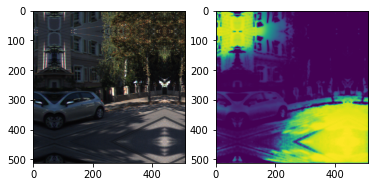

-------------------------------------------------- Epoch 10 / 20 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.538 ± 0.180            IoU: 0.590  ± 0.099


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.597 ± 0.357            IoU: 0.577  ± 0.232



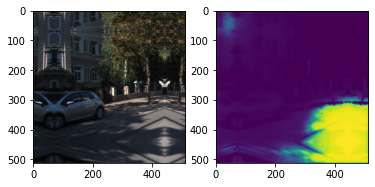

-------------------------------------------------- Epoch 11 / 20 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.525 ± 0.147            IoU: 0.596  ± 0.082


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 00011: reducing learning rate of group 0 to 5.0000e-03.
Loss: 0.632 ± 0.450            IoU: 0.577  ± 0.246



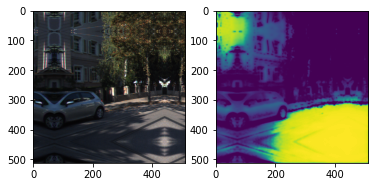

-------------------------------------------------- Epoch 12 / 20 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.491 ± 0.151            IoU: 0.619  ± 0.084


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.520 ± 0.298            IoU: 0.571  ± 0.217



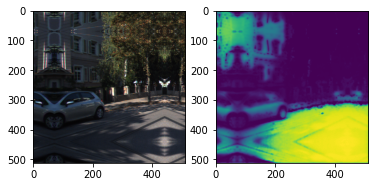

-------------------------------------------------- Epoch 13 / 20 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.469 ± 0.173            IoU: 0.636  ± 0.101


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.584 ± 0.361            IoU: 0.551  ± 0.235



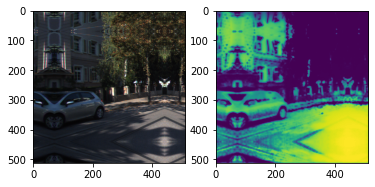

-------------------------------------------------- Epoch 14 / 20 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.459 ± 0.182            IoU: 0.643  ± 0.099


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.550 ± 0.303            IoU: 0.561  ± 0.220



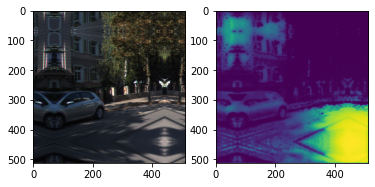

-------------------------------------------------- Epoch 15 / 20 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.452 ± 0.155            IoU: 0.650  ± 0.087


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.500 ± 0.320            IoU: 0.591  ± 0.231



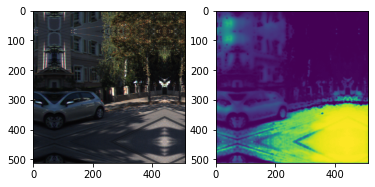

-------------------------------------------------- Epoch 16 / 20 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.439 ± 0.159            IoU: 0.656  ± 0.086


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.491 ± 0.342            IoU: 0.616  ± 0.234



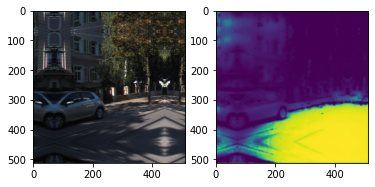

-------------------------------------------------- Epoch 17 / 20 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.450 ± 0.152            IoU: 0.649  ± 0.090


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.468 ± 0.295            IoU: 0.625  ± 0.224



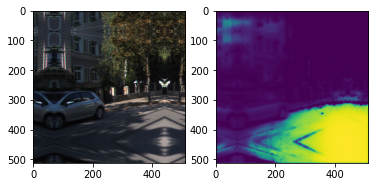

-------------------------------------------------- Epoch 18 / 20 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.452 ± 0.147            IoU: 0.646  ± 0.093


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.535 ± 0.280            IoU: 0.591  ± 0.209



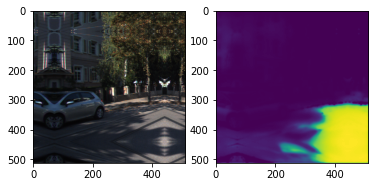

-------------------------------------------------- Epoch 19 / 20 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.447 ± 0.134            IoU: 0.651  ± 0.087


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.483 ± 0.292            IoU: 0.612  ± 0.225



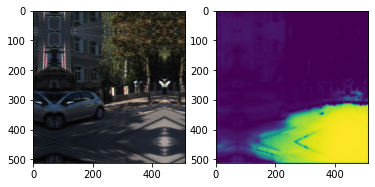

-------------------------------------------------- Epoch 20 / 20 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.443 ± 0.135            IoU: 0.650  ± 0.085


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 00020: reducing learning rate of group 0 to 2.5000e-03.
Loss: 0.561 ± 0.393            IoU: 0.589  ± 0.245



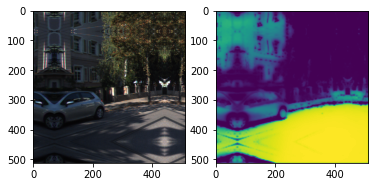

In [18]:
torch.cuda.empty_cache()

model = UNet().to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)

for epoch in tqdm(range(EPOCHS), desc='EPOCH'):
    print('-' * 50, f'Epoch {epoch + 1} / {EPOCHS}', '-' * 50)
    
    model.train(True) 
    model = train_model(model, train_loader, optimizer)
    
    model.train(False) 
    eval_model(model, test_loader, scheduler)